In [1]:
import tensorflow as tf
import keras
import cv2
import os
import PIL
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import pathlib
from keras.models import Sequential
from keras.layers import Dropout,Flatten,Dense,Conv2D,MaxPooling2D,BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
import tensorflow_hub as hub

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
dataset_dir=r'/kaggle/input/eye-diseases-classification/dataset'
dataset_dir

'/kaggle/input/eye-diseases-classification/dataset'

In [3]:
#we are going to all eye images one by one and read them into numpy array.for this,pathlib will be usefil
dataset_dir=pathlib.Path(dataset_dir)
dataset_dir

PosixPath('/kaggle/input/eye-diseases-classification/dataset')

In [4]:
cataract=len(list(dataset_dir.glob('cataract/*')))
print("total number of cataract:",cataract)
diabetic_retinopathy=len(list(dataset_dir.glob('diabetic_retinopathy/*')))
print("total number of diabetic_retinopathy:",diabetic_retinopathy)
glaucoma=len(list(dataset_dir.glob('glaucoma/*')))
print("total number of glaucoma:",glaucoma)
normal=len(list(dataset_dir.glob('normal/*')))
print("total number of normal:",normal)
#total=4217

total number of cataract: 1038
total number of diabetic_retinopathy: 1098
total number of glaucoma: 1007
total number of normal: 1074


In [5]:
#create a dictionary which has all the image path
eyes_image_dict={
    'cataract':list(dataset_dir.glob('cataract/*')),
    'diabetic_retinopathy':list(dataset_dir.glob('diabetic_retinopathy/*')),
    'glaucoma':list(dataset_dir.glob('glaucoma/*')),
    'normal':list(dataset_dir.glob('normal/*')),
}

In [6]:
#assigning a class number to each of these eyes images  randomly
eyes_labels_dict={
    'cataract':0,
    'diabetic_retinopathy':1,
    'glaucoma':2,
    'normal':3
}

In [7]:
img=cv2.imread(str(eyes_image_dict['cataract'][0]))
img.shape

(256, 256, 3)

**Read the image and convert it into 3 dimentional numpy array and resize it** 

In [8]:
x, y = [], []

for eye_name, images in eyes_image_dict.items():
    for image in images:
        img = cv2.imread(str(image))#opencv read the images and convert it into 3 dimensional numpy array
        resized_img = cv2.resize(img,(224,224))#resize it cause ML wants all training samples should be the same size
        x.append(resized_img)
        y.append(eyes_labels_dict[eye_name])


In [9]:
cataract=list(dataset_dir.glob('cataract/*'))
diabetic_retinopathy=list(dataset_dir.glob('diabetic_retinopathy/*'))
glaucoma=list(dataset_dir.glob('glaucoma/*'))
normal=list(dataset_dir.glob('normal/*'))


**Display some of the images**

In [10]:
r1=io.imread(str(cataract[0]))
r2=io.imread(str(diabetic_retinopathy[0]))
r3=io.imread(str(glaucoma[0]))
r4=io.imread(str(normal[0]))

(-0.5, 511.5, 511.5, -0.5)

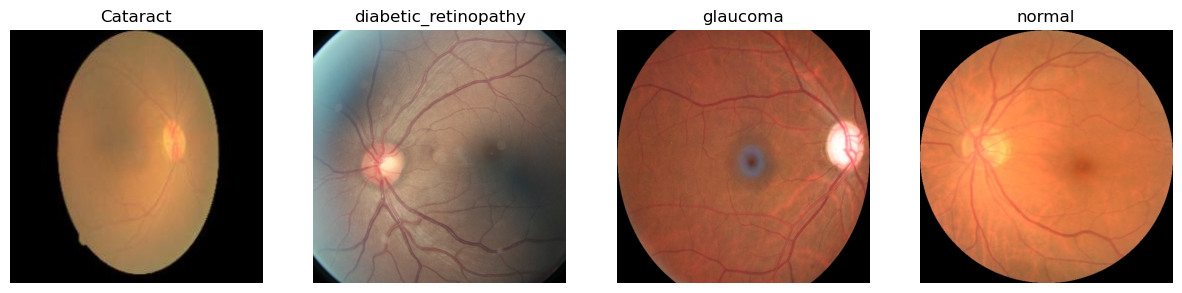

In [11]:
fig=plt.figure(figsize=(15,20))
plt.subplot(1,4,1) 
plt.imshow(r1)
plt.title("Cataract")
plt.axis("off")

plt.subplot(1,4,2) 
plt.imshow(r2)
plt.title("diabetic_retinopathy")
plt.axis("off")

plt.subplot(1,4,3) 
plt.imshow(r3)
plt.title("glaucoma")
plt.axis("off")

plt.subplot(1,4,4) 
plt.imshow(r4)
plt.title("normal")
plt.axis("off")

In [12]:
x=np.array(x)
y=np.array(y)

**Train-Test Split**

In [13]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=0,test_size=.2)

In [14]:
x_train=x_train.astype('float32')
x_test=x_test.astype('float32')


**Scaling/Normalization**

In [15]:
x_train_scaled=x_train/255
x_test_scaled=x_test/255

In [16]:
input_shape=(224,224,3)

In [17]:
data_augmentation = keras.Sequential([
  #types of transformation applied here
    layers.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(0.3)

])

**Build a CNN model**

In [18]:
num_classes=4
model=Sequential()
model.add(data_augmentation)
model.add(Conv2D(16,kernel_size=(3,3),
                 padding='same',
                 activation='relu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32,(3,3),
                padding='same',
                activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3),
                padding='same',
                activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128,(3,3),
                padding='same',
                activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))

#if y is hotencoded,then we use categorical crossentrophy otherwise SparseCategoricalCrossentropy
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=['accuracy'])



**train the model**

In [19]:
epochs=50
history=model.fit(x_train_scaled,
          y_train,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test_scaled,y_test))
score=model.evaluate(x_test_scaled,y_test,verbose=0)
print("Test loss:",score[0])
print("Test accuracy:",score[1])

Epoch 1/50
106/106 [==============================] - 17s 61ms/step - loss: 1.3529 - accuracy: 0.4764 - val_loss: 1.7116 - val_accuracy: 0.2571
Epoch 2/50
106/106 [==============================] - 5s 45ms/step - loss: 1.0987 - accuracy: 0.5488 - val_loss: 1.7772 - val_accuracy: 0.2571
Epoch 3/50
106/106 [==============================] - 5s 45ms/step - loss: 0.9787 - accuracy: 0.5870 - val_loss: 1.1744 - val_accuracy: 0.4479
Epoch 4/50
106/106 [==============================] - 5s 45ms/step - loss: 0.7971 - accuracy: 0.6697 - val_loss: 1.6151 - val_accuracy: 0.4846
Epoch 5/50
106/106 [==============================] - 5s 46ms/step - loss: 0.7749 - accuracy: 0.6798 - val_loss: 0.7263 - val_accuracy: 0.7073
Epoch 6/50
106/106 [==============================] - 5s 45ms/step - loss: 0.6797 - accuracy: 0.7311 - val_loss: 4.5643 - val_accuracy: 0.3791
Epoch 7/50
106/106 [==============================] - 5s 45ms/step - loss: 0.7842 - accuracy: 0.6745 - val_loss: 0.7720 - val_accuracy: 0.695

**save the model**

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 32)    

**plotting train vs test accuracy**

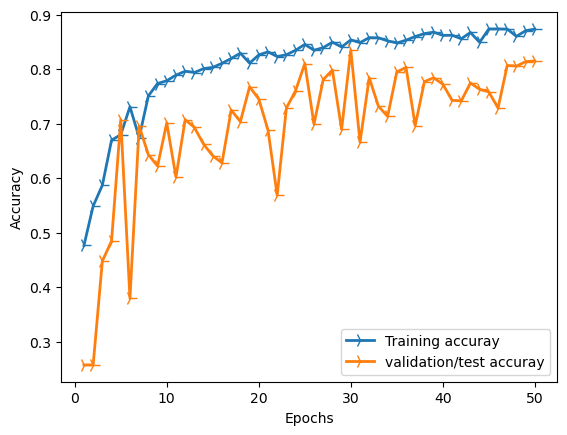

In [21]:

history_dict=history.history

acc_values=history_dict['accuracy']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,len(acc_values)+1)

line1=plt.plot(epochs,acc_values,label='Training accuray')
line2=plt.plot(epochs,val_acc_values,label='validation/test accuray')

plt.setp(line1,linewidth=2.0,marker='4',markersize='10.0')
plt.setp(line2,linewidth=2.0,marker='4',markersize='10.0')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

**plotting train vs test loss**

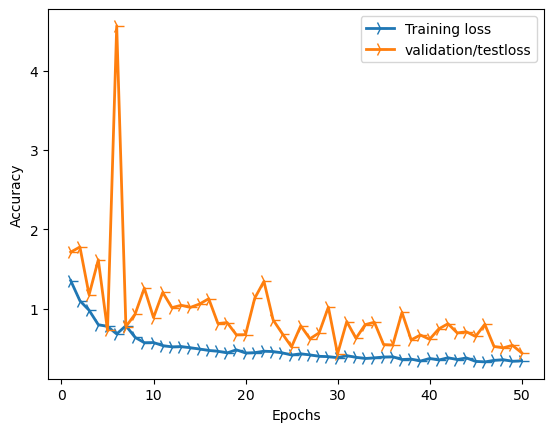

In [22]:

history_dict=history.history

loss_values=history_dict['loss']
val_loss_values=history_dict['val_loss']
epochs=range(1,len(loss_values)+1)

line1=plt.plot(epochs,loss_values,label='Training loss')
line2=plt.plot(epochs,val_loss_values,label='validation/testloss')

plt.setp(line1,linewidth=2.0,marker='4',markersize='10.0')
plt.setp(line2,linewidth=2.0,marker='4',markersize='10.0')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

**Classification report and confusion matrix**

27/27 [==============================] - 1s 15ms/step


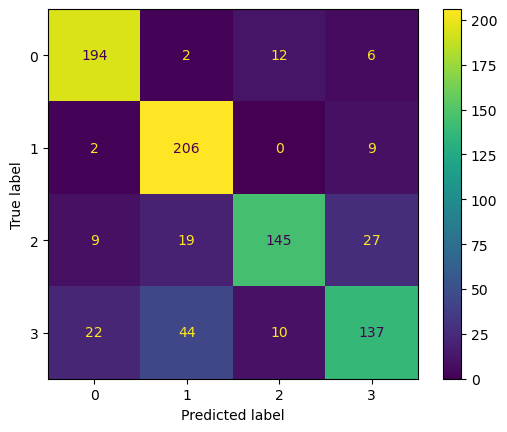

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       214
           1       0.76      0.95      0.84       217
           2       0.87      0.72      0.79       200
           3       0.77      0.64      0.70       213

    accuracy                           0.81       844
   macro avg       0.81      0.81      0.80       844
weighted avg       0.81      0.81      0.80       844



In [23]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred=model.predict(x_test_scaled).round()
y_pred = np.argmax(y_pred,axis=1)
cm=confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()
print(classification_report(y_test,y_pred))



# Transfer learning-EfficientNet B0

In [24]:
#include all of the layers except the last layer
feature_extractor_model = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)
#trainable=False means freeze the layers ,we do not train

In [25]:
num_of_eyes = 4

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,# previous layers are already trained
  tf.keras.layers.Dense(num_of_eyes)# last layer is only mine
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              4049564   
                                                                 
 dense_2 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 4,054,688
Trainable params: 5,124
Non-trainable params: 4,049,564
_________________________________________________________________


In [26]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])
model.fit(x_train_scaled,
          y_train,
          epochs=50,
          verbose=1,
          validation_data=(x_test_scaled,y_test))
score=model.evaluate(x_test_scaled,y_test,verbose=0)

Epoch 1/50
106/106 [==============================] - 20s 99ms/step - loss: 0.7558 - accuracy: 0.7234 - val_loss: 0.5341 - val_accuracy: 0.8092
Epoch 2/50
106/106 [==============================] - 7s 70ms/step - loss: 0.5018 - accuracy: 0.8221 - val_loss: 0.4407 - val_accuracy: 0.8472
Epoch 3/50
106/106 [==============================] - 7s 70ms/step - loss: 0.4359 - accuracy: 0.8515 - val_loss: 0.4009 - val_accuracy: 0.8626
Epoch 4/50
106/106 [==============================] - 7s 70ms/step - loss: 0.3951 - accuracy: 0.8693 - val_loss: 0.3745 - val_accuracy: 0.8720
Epoch 5/50
106/106 [==============================] - 7s 70ms/step - loss: 0.3667 - accuracy: 0.8752 - val_loss: 0.3564 - val_accuracy: 0.8863
Epoch 6/50
106/106 [==============================] - 7s 70ms/step - loss: 0.3496 - accuracy: 0.8829 - val_loss: 0.3385 - val_accuracy: 0.8803
Epoch 7/50
106/106 [==============================] - 8s 71ms/step - loss: 0.3330 - accuracy: 0.8885 - val_loss: 0.3237 - val_accuracy: 0.886

27/27 [==============================] - 2s 55ms/step


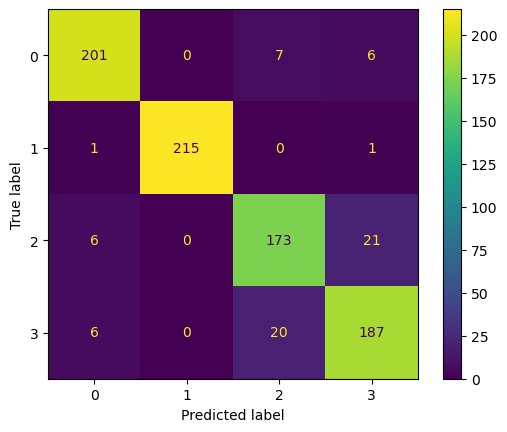

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       214
           1       1.00      0.99      1.00       217
           2       0.86      0.86      0.86       200
           3       0.87      0.88      0.87       213

    accuracy                           0.92       844
   macro avg       0.92      0.92      0.92       844
weighted avg       0.92      0.92      0.92       844



In [27]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred=model.predict(x_test_scaled).round()
y_pred = np.argmax(y_pred,axis=1)
cm=confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()
print(classification_report(y_test,y_pred))


# VGG16

In [29]:
from keras.applications import VGG16
reslayer=VGG16(input_shape=(224,224,3),weights='imagenet',include_top=False)
for layer in reslayer.layers:
    layer.trainable=False

58889256/58889256 [==============================] - 0s 0us/step


In [30]:
num_of_eyes = 4

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,# previous layers are already trained
  tf.keras.layers.Dense(num_of_eyes)# last layer is only mine
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              4049564   
                                                                 
 dense_3 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 4,054,688
Trainable params: 5,124
Non-trainable params: 4,049,564
_________________________________________________________________


In [34]:
num_classes=4
model=Sequential()
model.add(data_augmentation)
model.add(reslayer)
model.add(Flatten())

model.add(Dense(1024,activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.3))

model.add(Dense(256,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes,activation='softmax'))

In [37]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])
model.fit(x_train_scaled,
          y_train,
          epochs=50,
          verbose=1,
          validation_data=(x_test_scaled,y_test))
score=model.evaluate(x_test_scaled,y_test,verbose=0)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


106/106 [==============================] - 31s 222ms/step - loss: 1.6469 - accuracy: 0.4343 - val_loss: 0.8682 - val_accuracy: 0.6114
Epoch 2/50
106/106 [==============================] - 19s 177ms/step - loss: 0.9508 - accuracy: 0.5787 - val_loss: 0.7873 - val_accuracy: 0.6671
Epoch 3/50
106/106 [==============================] - 18s 175ms/step - loss: 0.8848 - accuracy: 0.6181 - val_loss: 0.7193 - val_accuracy: 0.7014
Epoch 4/50
106/106 [==============================] - 18s 171ms/step - loss: 0.8142 - accuracy: 0.6597 - val_loss: 0.6851 - val_accuracy: 0.7441
Epoch 5/50
106/106 [==============================] - 18s 170ms/step - loss: 0.8062 - accuracy: 0.6597 - val_loss: 0.6668 - val_accuracy: 0.7879
Epoch 6/50
106/106 [==============================] - 18s 174ms/step - loss: 0.7770 - accuracy: 0.6730 - val_loss: 0.6358 - val_accuracy: 0.7524
Epoch 7/50
106/106 [==============================] - 18s 175ms/step - loss: 0.7432 - accuracy: 0.6813 - val_loss: 0.6314 - val_accuracy: 0.7

In [38]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dense_10 (Dense)            (None, 1024)              25691136  
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_11 (Dense)            (None, 512)               524800    
                                                                 
 dropout_5 (Dropout)         (None, 512)              

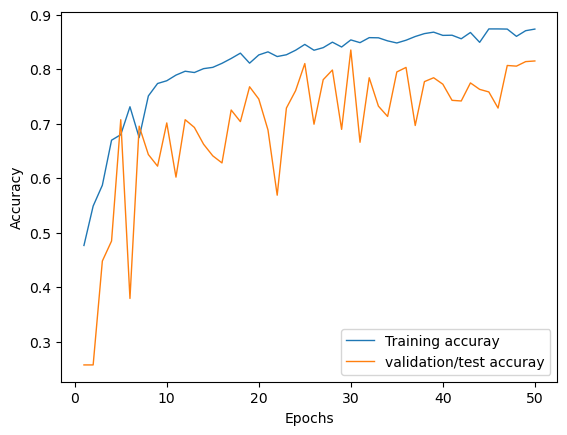

In [39]:
history_dict=history.history

acc_values=history_dict['accuracy']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,len(acc_values)+1)

line1=plt.plot(epochs,acc_values,label='Training accuray')
line2=plt.plot(epochs,val_acc_values,label='validation/test accuray')

plt.setp(line1,linewidth=1.0,markersize='5.0')
plt.setp(line2,linewidth=1.0,markersize='5.0')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.65, max(max(acc_values), max(val_acc_values)))
#plt.yticks([0.65,0.70,0.75,0.80,0.85, 0.90, 0.95,1.00])

plt.legend()

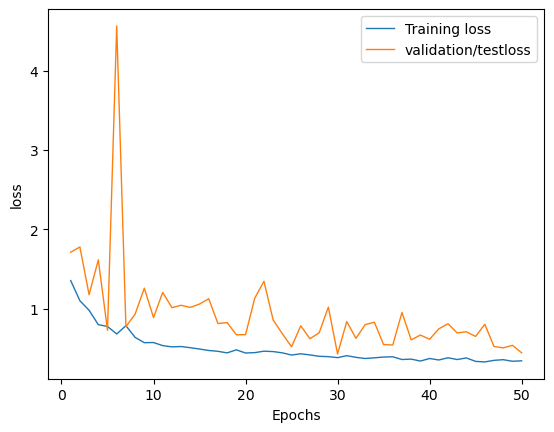

In [40]:
history_dict=history.history

loss_values=history_dict['loss']
val_loss_values=history_dict['val_loss']
epochs=range(1,len(loss_values)+1)

line1=plt.plot(epochs,loss_values,label='Training loss')
line2=plt.plot(epochs,val_loss_values,label='validation/testloss')

plt.setp(line1,linewidth=1.0,markersize='5.0')
plt.setp(line2,linewidth=1.0,markersize='5.0')
plt.xlabel('Epochs')
plt.ylabel('loss')

#plt.ylim(0, max(max(loss_values), max(val_loss_values)))
#plt.yticks([0,0.1,0.2,0.3,0.4,0.5, 0.6, 0.7,0.8,0.9,1.0])
plt.legend()
plt.show()

27/27 [==============================] - 4s 136ms/step


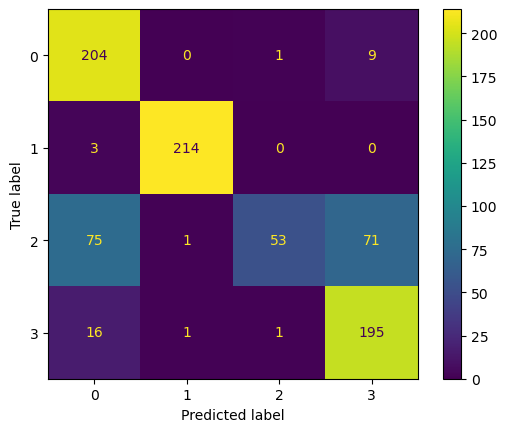

              precision    recall  f1-score   support

           0       0.68      0.95      0.80       214
           1       0.99      0.99      0.99       217
           2       0.96      0.27      0.42       200
           3       0.71      0.92      0.80       213

    accuracy                           0.79       844
   macro avg       0.84      0.78      0.75       844
weighted avg       0.84      0.79      0.76       844



In [42]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred=model.predict(x_test_scaled).round()
y_pred = np.argmax(y_pred,axis=1)
cm=confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()
print(classification_report(y_test,y_pred))

# Mobilenet

In [43]:
from keras.applications import MobileNet
reslayer=MobileNet(input_shape=(224,224,3),weights='imagenet',include_top=False)
for layer in reslayer.layers:
    layer.trainable=False

17225924/17225924 [==============================] - 0s 0us/step


In [45]:
num_classes=4
model=Sequential()
model.add(data_augmentation)
model.add(reslayer)
model.add(Flatten())

model.add(Dense(1024,activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.3))

model.add(Dense(256,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes,activation='softmax'))

In [46]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])
model.fit(x_train_scaled,
          y_train,
          epochs=50,
          verbose=1,
          validation_data=(x_test_scaled,y_test))
score=model.evaluate(x_test_scaled,y_test,verbose=0)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


106/106 [==============================] - 12s 77ms/step - loss: 5.8907 - accuracy: 0.5508 - val_loss: 0.8184 - val_accuracy: 0.6339
Epoch 2/50
106/106 [==============================] - 6s 59ms/step - loss: 0.9765 - accuracy: 0.6736 - val_loss: 0.6230 - val_accuracy: 0.7701
Epoch 3/50
106/106 [==============================] - 6s 59ms/step - loss: 0.8309 - accuracy: 0.6973 - val_loss: 0.5932 - val_accuracy: 0.7713
Epoch 4/50
106/106 [==============================] - 6s 59ms/step - loss: 0.6830 - accuracy: 0.7438 - val_loss: 0.5836 - val_accuracy: 0.7796
Epoch 5/50
106/106 [==============================] - 6s 58ms/step - loss: 0.6291 - accuracy: 0.7634 - val_loss: 0.5773 - val_accuracy: 0.7867
Epoch 6/50
106/106 [==============================] - 6s 59ms/step - loss: 0.6572 - accuracy: 0.7640 - val_loss: 0.5923 - val_accuracy: 0.8057
Epoch 7/50
106/106 [==============================] - 6s 58ms/step - loss: 0.5528 - accuracy: 0.7922 - val_loss: 0.5216 - val_accuracy: 0.8211
Epoch 8/5

In [47]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 50176)             0         
                                                                 
 dense_18 (Dense)            (None, 1024)              51381248  
                                                                 
 dropout_10 (Dropout)        (None, 1024)              0         
                                                                 
 dense_19 (Dense)            (None, 512)               524800    
                                                      

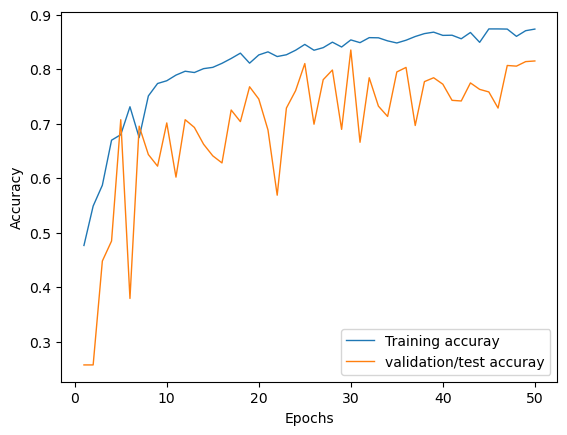

In [48]:
history_dict=history.history

acc_values=history_dict['accuracy']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,len(acc_values)+1)

line1=plt.plot(epochs,acc_values,label='Training accuray')
line2=plt.plot(epochs,val_acc_values,label='validation/test accuray')

plt.setp(line1,linewidth=1.0,markersize='5.0')
plt.setp(line2,linewidth=1.0,markersize='5.0')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.65, max(max(acc_values), max(val_acc_values)))
#plt.yticks([0.65,0.70,0.75,0.80,0.85, 0.90, 0.95,1.00])

plt.legend()

In [ ]:
history_dict=history.history

loss_values=history_dict['loss']
val_loss_values=history_dict['val_loss']
epochs=range(1,len(loss_values)+1)

line1=plt.plot(epochs,loss_values,label='Training loss')
line2=plt.plot(epochs,val_loss_values,label='validation/testloss')

plt.setp(line1,linewidth=1.0,markersize='5.0')
plt.setp(line2,linewidth=1.0,markersize='5.0')
plt.xlabel('Epochs')
plt.ylabel('loss')

#plt.ylim(0, max(max(loss_values), max(val_loss_values)))
#plt.yticks([0,0.1,0.2,0.3,0.4,0.5, 0.6, 0.7,0.8,0.9,1.0])
plt.legend()
plt.show()

27/27 [==============================] - 1s 37ms/step


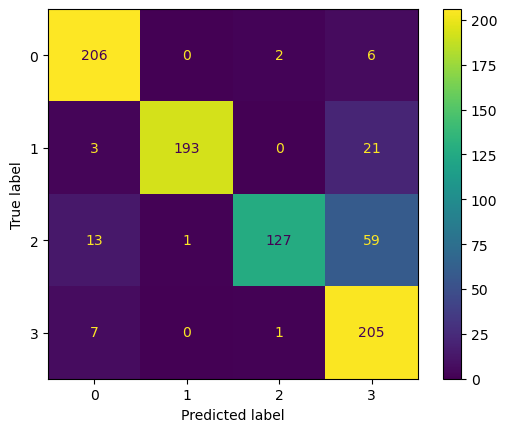

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       214
           1       0.99      0.89      0.94       217
           2       0.98      0.64      0.77       200
           3       0.70      0.96      0.81       213

    accuracy                           0.87       844
   macro avg       0.89      0.86      0.86       844
weighted avg       0.89      0.87      0.86       844



In [49]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred=model.predict(x_test_scaled).round()
y_pred = np.argmax(y_pred,axis=1)
cm=confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()
print(classification_report(y_test,y_pred))

# Xception

In [50]:
from keras.applications import Xception
reslayer=Xception(input_shape=(224,224,3),weights='imagenet',include_top=False)
for layer in reslayer.layers:
    layer.trainable=False

83683744/83683744 [==============================] - 0s 0us/step


In [52]:
num_classes=4
model=Sequential()
model.add(data_augmentation)
model.add(reslayer)
model.add(Flatten())

model.add(Dense(1024,activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.3))

model.add(Dense(256,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes,activation='softmax'))

In [53]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])
model.fit(x_train_scaled,
          y_train,
          epochs=50,
          verbose=1,
          validation_data=(x_test_scaled,y_test))
score=model.evaluate(x_test_scaled,y_test,verbose=0)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


106/106 [==============================] - 33s 247ms/step - loss: 5.5876 - accuracy: 0.4984 - val_loss: 0.8674 - val_accuracy: 0.6291
Epoch 2/50
106/106 [==============================] - 22s 205ms/step - loss: 1.0898 - accuracy: 0.5784 - val_loss: 0.7439 - val_accuracy: 0.6967
Epoch 3/50
106/106 [==============================] - 21s 200ms/step - loss: 0.8611 - accuracy: 0.6448 - val_loss: 0.6737 - val_accuracy: 0.7464
Epoch 4/50
106/106 [==============================] - 21s 203ms/step - loss: 0.8109 - accuracy: 0.6665 - val_loss: 0.6780 - val_accuracy: 0.6872
Epoch 5/50
106/106 [==============================] - 22s 206ms/step - loss: 0.8031 - accuracy: 0.6682 - val_loss: 0.7641 - val_accuracy: 0.6576
Epoch 6/50
106/106 [==============================] - 22s 206ms/step - loss: 0.7545 - accuracy: 0.6997 - val_loss: 0.6650 - val_accuracy: 0.7073
Epoch 7/50
106/106 [==============================] - 21s 203ms/step - loss: 0.7332 - accuracy: 0.7136 - val_loss: 0.6396 - val_accuracy: 0.7

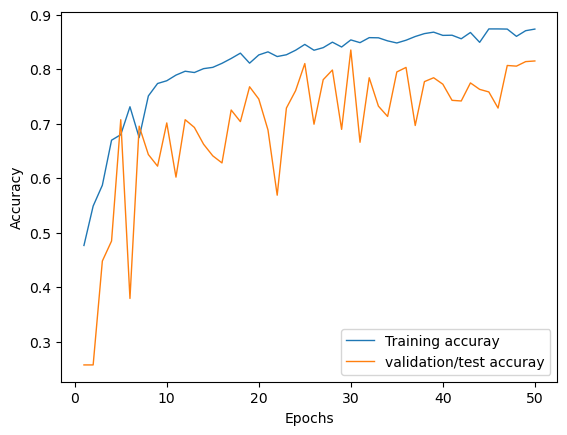

In [54]:
history_dict=history.history

acc_values=history_dict['accuracy']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,len(acc_values)+1)

line1=plt.plot(epochs,acc_values,label='Training accuray')
line2=plt.plot(epochs,val_acc_values,label='validation/test accuray')

plt.setp(line1,linewidth=1.0,markersize='5.0')
plt.setp(line2,linewidth=1.0,markersize='5.0')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.65, max(max(acc_values), max(val_acc_values)))
#plt.yticks([0.65,0.70,0.75,0.80,0.85, 0.90, 0.95,1.00])

plt.legend()

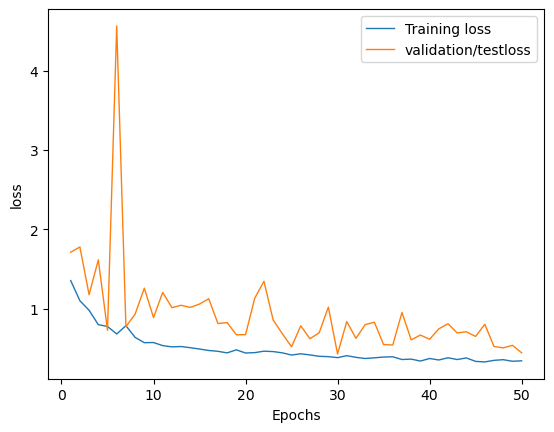

In [55]:
history_dict=history.history

loss_values=history_dict['loss']
val_loss_values=history_dict['val_loss']
epochs=range(1,len(loss_values)+1)

line1=plt.plot(epochs,loss_values,label='Training loss')
line2=plt.plot(epochs,val_loss_values,label='validation/testloss')

plt.setp(line1,linewidth=1.0,markersize='5.0')
plt.setp(line2,linewidth=1.0,markersize='5.0')
plt.xlabel('Epochs')
plt.ylabel('loss')

#plt.ylim(0, max(max(loss_values), max(val_loss_values)))
#plt.yticks([0,0.1,0.2,0.3,0.4,0.5, 0.6, 0.7,0.8,0.9,1.0])
plt.legend()
plt.show()

27/27 [==============================] - 5s 145ms/step


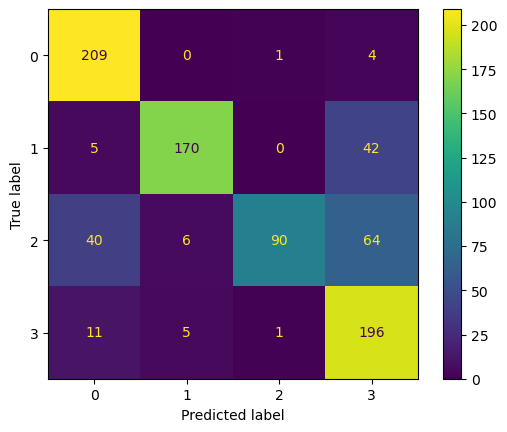

              precision    recall  f1-score   support

           0       0.79      0.98      0.87       214
           1       0.94      0.78      0.85       217
           2       0.98      0.45      0.62       200
           3       0.64      0.92      0.76       213

    accuracy                           0.79       844
   macro avg       0.84      0.78      0.77       844
weighted avg       0.83      0.79      0.78       844



In [56]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred=model.predict(x_test_scaled).round()
y_pred = np.argmax(y_pred,axis=1)
cm=confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()
print(classification_report(y_test,y_pred))